In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import multiprocessing
import torchvision
import timm
import os
from transformers import *
from datasets import load_dataset
from PIL import Image
from torchinfo import summary
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import time

torch.cuda.empty_cache()
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


### Data Loading and Pretrained models

In [2]:
def image_fetch(src,image_paths):
    l=os.listdir(src)
    if(len(l)!=0):
        for i in range(len(l)):
            if(".jpg" in l[i] or ".jpeg" in l[i] or ".png" in l[i]):
                image_paths.append(str(src+l[i]))
            elif("." not in l[i]):
                try:
                    image_fetch(str(src+l[i]+"/"),image_paths)
                except:
                    continue
                            
def class_fetch(image_paths)->(list,dict):
    s=set()
    for i in image_paths:
        s.add(i.split("/")[-2])
    d={}
    count=0
    for i in s:
        d[i]=count
        count+=1
    return list(s),d

In [3]:
class modified_dataset_loader(Dataset):
    
    def __init__(self,targ_dir=None,paths=None,transformations=None):

        if(targ_dir!=None):
            self.transform=transformations
            self.paths=[]
            image_fetch(targ_dir,self.paths)
            self.classes, self.class_to_idx=class_fetch(self.paths)
        else:
            self.transform=transformations
            self.paths=paths
            self.classes, self.class_to_idx=class_fetch(self.paths)
            


    def load_image(self,index)-> Image.Image:
        image_path=self.paths[index]
        return Image.open(image_path).convert('RGB')

    def __len__(self):
        return len(self.paths)

    def __getitem__(self,index):
        image=self.load_image(index)
        class_val=self.class_to_idx[(self.paths[index]).split("/")[-2]]
        if(self.transform):
            image=self.transform(image)
        return image,class_val

In [4]:
batch_size=32
cpu_count=multiprocessing.cpu_count()
model_name="timm/resnetaa50d.sw_in12k_ft_in1k"

model = timm.create_model(model_name, pretrained=True)

data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

transform_data=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Resize(size=(384,384))])

data_path=[]
image_fetch("../../../SIH_AMAL_SSD/Dataset/",data_path)

train,test=train_test_split(data_path,test_size=0.5)
test,val=train_test_split(test,test_size=0.5)

train_data=modified_dataset_loader(paths=train,transformations=transform_data)
test_data=modified_dataset_loader(paths=test,transformations=transform_data)
val_data=modified_dataset_loader(paths=val,transformations=transform_data)

print(f"No. of images in Training set: {len(train)}\nNo. of images in Validation set: {len(val)}\nNo. of images in Test set: {len(test)}")

No. of images in Training set: 78800
No. of images in Validation set: 39400
No. of images in Test set: 39400


In [5]:
train_loader=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)
test_loader=torch.utils.data.DataLoader(test_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)
val_loader=torch.utils.data.DataLoader(val_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)

### 2nd Model

In [6]:
model2=timm.create_model("timm/resnet26.bt_in1k",pretrained=True)

### Freezing layers and slight modification to model

In [7]:
count=0
for param in model.parameters(): #152 layers
    if(count>=100):
        break
    param.requires_grad=False
    count+=1

count=0
for param in model2.parameters():  #89 params
    if(count>=70):
        break
    param.requires_grad=False
    count+=1

class dual_model(nn.Module):
    def __init__(self,model_resnet_big,model_resnet_small,classes):
        super().__init__()
        self.m1=model_resnet_big
        self.m2=model_resnet_small
        self.classifier=nn.Sequential(nn.Linear(in_features=2000,out_features=1024),
                                     nn.ReLU(),
                                     nn.BatchNorm1d(num_features=1024),
                                     nn.Dropout(),
                                     nn.Linear(in_features=1024,out_features=512),
                                     nn.ELU(),
                                     nn.Dropout(),
                                     nn.BatchNorm1d(num_features=512),
                                     nn.Linear(in_features=512,out_features=64),
                                     nn.ReLU(),
                                     nn.Linear(in_features=64,out_features=classes))

    
    def forward(self,x):
        self.output=torch.concat((self.m1(x),self.m2(x)),dim=1)
        self.final=self.classifier(self.output)
        return self.final

In [8]:
#model=modified_model(model,len(train_data.classes),modify_bool=False,add_block_dropout_bool=True).to(device)
#model=simple_cnn(len(train_data.classes).to(device)
model=dual_model(model,model2,len(train_data.classes)).to(device)

### Slight Visualizing

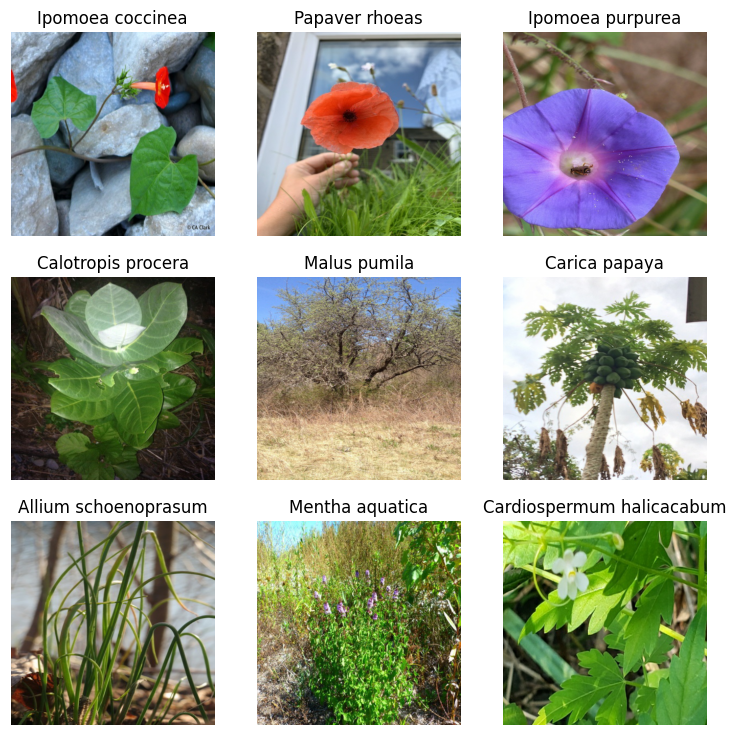

In [9]:
plt.figure(figsize=(9,9))
plt.axis(False)
for i in range(1,10):
    rand_ind=torch.randint(0,batch_size-1,size=(1,)).item()
    data=next(iter(train_loader))
    label=data[1][rand_ind]
    image=data[0][rand_ind].permute(1,2,0)
    plt.subplot(3,3,i)
    plt.title(train_data.classes[label.item()])
    plt.axis(False)
    plt.imshow(image)
    

### Misc.

In [10]:
optimizer=torch.optim.Adam(model.parameters())
loss_fn=nn.CrossEntropyLoss()

#log_dir = "./"+model_name+"feature_extractor_tensorboard"
#writer = SummaryWriter(log_dir=log_dir)

def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)
    

### Testing the model (image)

In [11]:
model.eval()
with torch.inference_mode():
    x,y=next(iter(train_loader))
    x=x.to(device)
    y=y.to(device)
    logits=model(x)
    print(logits)
    print(loss_fn(logits.squeeze(),y))
    print(accuracy_fn(logits,y))

tensor([[-0.2435,  0.1827,  0.1040,  ...,  0.3972,  0.0897,  0.1766],
        [-0.1327,  0.1017,  0.1062,  ...,  0.3836,  0.0447,  0.1174],
        [-0.2458,  0.1776,  0.0190,  ...,  0.4408,  0.1140,  0.2165],
        ...,
        [-0.2134,  0.1426, -0.0067,  ...,  0.4171,  0.0739,  0.2341],
        [-0.1799,  0.1237, -0.0155,  ...,  0.3602,  0.1058,  0.1737],
        [-0.2395,  0.0853, -0.0218,  ...,  0.3862,  0.0729,  0.2641]],
       device='cuda:0')
tensor(6.4140, device='cuda:0')
0.0


### Training Loop for image classification

In [12]:
epochs=10

train_accuracy=[]
val_accuracy=[]
train_loss=[]
val_loss=[]

for i in tqdm(range(epochs)):
    print("Training:")
    model.train()
    
    #Defining accuracy and loss for train and val data
    temp_train_accuracy=[]
    temp_val_accuracy=[]
    temp_train_loss=[]
    temp_val_loss=[]

    net_train_accuracy=0
    net_val_accuracy=0
    net_train_loss=0
    net_val_loss=0
    
    with tqdm(total=len(train_loader)) as pbar:
        for x,y in train_loader:
                x=x.to(device)
                y=y.to(device)
    
                #Calculating model output
                logits=model(x)
    
                #Reseting any old gradient values
                optimizer.zero_grad()
                loss=loss_fn(logits.squeeze(),y)

            
                #Track of metrics        
                accuracy_train=accuracy_fn(logits.type(torch.float32),y)
                temp_train_accuracy.append(accuracy_train)
                temp_train_loss.append(loss.item())
    
                #Back Propogation
                loss.backward()
            
                #Update Parameters
                optimizer.step()
            
                #Progress Bar Update
                pbar.update(1)
        pbar.close()
    #Tensorboard & Metrics for the dataset
    net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
    net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
    train_accuracy.append(net_train_accuracy)
    train_loss.append(net_train_loss)
    #writer.add_scalar("Train Accuracy",net_train_accuracy,i)
    #writer.add_scalar("Train Loss",net_train_loss,i)

    #Evaluation
    print("Testing on validation data:")
    model.eval()

    with tqdm(total=len(val_loader)) as pbar2:
        for x,y in val_loader:
            x=x.to(device)
            y=y.to(device)
            
            #Setting inference mode
            with torch.inference_mode():
                logits=model(x)
                loss=loss_fn(logits.squeeze().type(torch.float32),y)

                #Track of metrics
                accuracy_test=accuracy_fn(logits,y)
                temp_val_accuracy.append(accuracy_test)
                temp_val_loss.append(loss.item())

                #Progress Bar Update
                pbar2.update(1)
        pbar2.close()

    #Tensorboard & Metrics for the dataset
    net_val_accuracy=sum(temp_val_accuracy)/len(temp_val_accuracy)
    net_val_loss=sum(temp_val_loss)/len(temp_val_loss)
    val_accuracy.append(net_val_accuracy)
    val_loss.append(net_val_loss)
    #writer.add_scalar("Val Accuracy",net_val_accuracy,i)
    #writer.add_scalar("Val Loss",net_val_loss,i)

    '''
    #Saving the model
    try:
        os.makedirs(f"./{model_name}_feature_extractor/")
    except Exception as e:
        pass
    torch.save(model.state_dict(),f"./{model_name}_feature_extractor/checkpoint-{i+1}.pth")
    '''
    
    print(f"Epoch {i+1}:\nTrain Accuracy: {net_train_accuracy}  Train Loss: {net_train_loss}  Val Accuracy: {net_val_accuracy}  Val Loss: {net_val_loss}")
    print("\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Training:


  0%|          | 0/2463 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/1232 [00:00<?, ?it/s]

Epoch 1:
Train Accuracy: 0.0194884287454324  Train Loss: 5.666559958719307  Val Accuracy: 0.04096489448051948  Val Loss: 8.300248113932547


Training:


  0%|          | 0/2463 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/1232 [00:00<?, ?it/s]

Epoch 2:
Train Accuracy: 0.08335870889159562  Train Loss: 4.487593640557064  Val Accuracy: 0.1260146103896104  Val Loss: 5.7071177299533575


Training:


  0%|          | 0/2463 [00:00<?, ?it/s]

Testing on validation data:


  0%|          | 0/1232 [00:00<?, ?it/s]

Epoch 3:
Train Accuracy: 0.1432196508323183  Train Loss: 3.93886744022563  Val Accuracy: 0.16847605519480519  Val Loss: 5.347475397702936


Training:


  0%|          | 0/2463 [00:00<?, ?it/s]

KeyboardInterrupt: 